# Stock Price Predictor but playing with different parameters

In [3]:
# Import dependencies

# Machine Learning
# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F
import torchsummary
# Tensoflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense


# Data manipulation
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Training example specific
from talib import RSI, BBANDS, MACD

In [4]:
def clean_data():
    # Import and concatenate data
    df1 = pd.read_csv('Good Data/S&P 500 Historical Data (1).csv')
    df2 = pd.read_csv('Good Data/S&P 500 Historical Data (2).csv')
    df3 = pd.read_csv('Good Data/S&P 500 Historical Data (3).csv')
    df = pd.concat([df3, df2, df1], axis = 0, join = 'outer')
    
    # Set Date column to datetime format, and set as index
    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y', errors = 'coerce')
    df = df.set_index('Date')
    
    # Clean data and rename remaining columns to make typing easier
    df = df.drop(df[df["Price"]==0].index)
    df = df.drop(['High', 'Low', 'Vol.', 'Change %'], axis = 1)
    df = df.rename(columns={'Price': 'close'})
    df = df.rename(columns={'Open': 'open'})
    df = df.dropna()
    
    # Remove commas and convert to float
    df['close'] = df['close'].str.replace(',','')
    df['open'] = df['open'].str.replace(',','')
    df['close'] = df['close'].astype(float)
    df['open'] = df['open'].astype(float)
    
    # Calculate the percent change and the daily returns
    df['gradient'] = (df['close'].shift(1) - df['close']) / df['close'].shift(1)
    df['returns'] = df['gradient'] * 100
    
    # Include SMA 30, 50, 70 and EMA 30, 50, 70
    df['SMA50'] = df['close'].rolling(50).mean()
    df['SMA70'] = df['close'].rolling(70).mean()
    df['SMA30'] = df['close'].rolling(30).mean()
    df['EMA30'] = df['close'].ewm(span = 30, adjust = False). mean()
    df['EMA50'] = df['close'].ewm(span = 50, adjust = False). mean()
    df['EMA70'] = df['close'].ewm(span = 70, adjust = False). mean()
    
    #Using RSI and BBbands as technical indicators
    df['rsi'] = RSI(df['close'])
    high, mid, low = BBANDS(df['close'], timeperiod = 50)
    df = df.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index = df.index))
    df = df.dropna()
    
    # We want to use data from day d to predict close of day d+1
    # Shift close data down and assign to 'target' col
    df['target'] = df['close'].shift(1)
    df = df.dropna()
    return df

In [10]:
df = clean_data()
print(df.shape)

(10800, 14)


In [11]:
df.head(10)

,close,open,gradient,returns,SMA50,SMA70,SMA30,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target
Date,,,,,,,,,,,,,,
1979-12-27,108.0,108.0,-0.001855,-0.185529,112.584,109.945714,111.020000,109.895434,110.279890,110.397340,40.685306,119.245935,105.922065,107.8
1979-12-28,107.8,107.8,0.000927,0.092678,112.598,109.862857,111.296667,110.026154,110.372947,110.466828,39.475124,119.224189,105.971811,108.0
1979-12-31,107.9,107.9,0.000000,0.000000,112.580,109.754286,111.633333,110.179681,110.477965,110.544128,39.852636,119.262874,105.897126,107.8
1980-01-01,107.9,107.9,-0.019849,-1.984877,112.552,109.658571,111.940000,110.336901,110.583188,110.620769,39.852636,119.324207,105.779793,107.9
1980-01-02,105.8,105.8,-0.005703,-0.570342,112.550,109.590000,112.273333,110.504963,110.692706,110.699632,27.256004,119.327758,105.772242,107.9
1980-01-03,105.2,105.2,0.012207,1.220657,112.572,109.565714,112.693333,110.829443,110.892409,110.841650,22.976345,119.268631,105.875369,105.8
1980-01-04,106.5,106.5,0.002809,0.280899,112.580,109.545714,113.076667,111.217681,111.124752,111.005176,26.061032,119.242252,105.917748,105.2
1980-01-07,106.8,106.8,0.019284,1.928375,112.558,109.492857,113.373333,111.543038,111.313517,111.135761,26.832988,119.307114,105.808886,106.5
1980-01-08,108.9,108.9,0.001833,0.183318,112.468,109.432857,113.660000,111.870144,111.497742,111.261435,33.231228,119.629278,105.306722,106.8


In [12]:
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}:{count}')

close:0
open:0
gradient:0
returns:0
SMA50:0
SMA70:0
SMA30:0
EMA30:0
EMA50:0
EMA70:0
rsi:0
bb_high:0
bb_low:0
target:0


In [13]:
df = df.drop(['gradient', 'returns'], axis = 1)

split_ratio = 0.8
split = math.floor(df.shape[0] * split_ratio)

df_train = df[:split]
df_test = df[split:]

array = df.to_numpy()

X_train_data = array[:split, :-1]
y_train_data = array[:split, -1].reshape(-1, 1)

X_test_data = array[split:, :-1]
y_test_data = array[split:, -1].reshape(-1, 1)

In [14]:
print(X_train_data.shape)
print(y_train_data.shape)

print(X_test_data.shape)
print(y_test_data.shape)

(8640, 11)
(8640, 1)
(2160, 11)
(2160, 1)


In [15]:
# Create standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train_data)

# Standardize the training and test data
X_train_scaled = scaler.fit_transform(X_train_data)
y_train_scaled = scaler.fit_transform(y_train_data)

X_test_scaled = scaler.fit_transform(X_test_data)
y_test_scaled = scaler.fit_transform(y_test_data)

<function matplotlib.pyplot.show(close=None, block=None)>

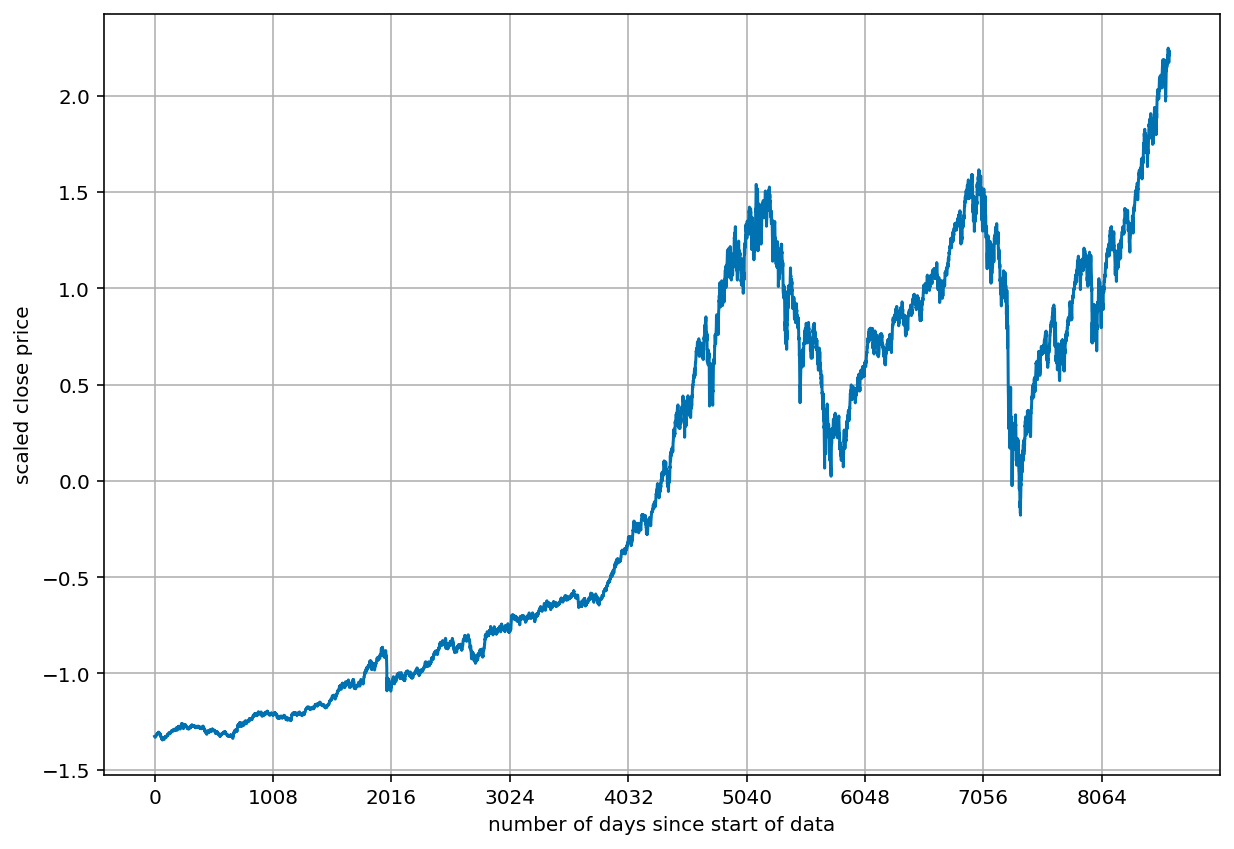

In [16]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(y_train_scaled[:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.grid(True)
plt.show

# Prediction Modelling

In [17]:
# Create the training data
X_train, y_train = [], []

time_step = 40

length_train = math.floor(df.shape[0] * 0.8) # length data * 0.8

# Setting up training array
for i in range(time_step, X_train_scaled.shape[0]):
    X_train.append(X_train_scaled[i - time_step : i, :])
    y_train.append(y_train_scaled[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Creating the test data
X_test, y_test = [], []

length_train = y_test_data.shape[0]

# Setting up test array
for i in range(time_step, length_train):
    X_test.append(X_test_scaled[i - time_step : i, :])
    y_test.append(y_test_scaled[i])

X_test, y_test = np.array(X_test), np.array(y_test)

# y_train = np.reshape(y_train, (y_train.shape[0],1))
# y_test = np.reshape(y_test, (-1,1))

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(8600, 40, 11)
(8600, 1)
(2120, 40, 11)
(2120, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

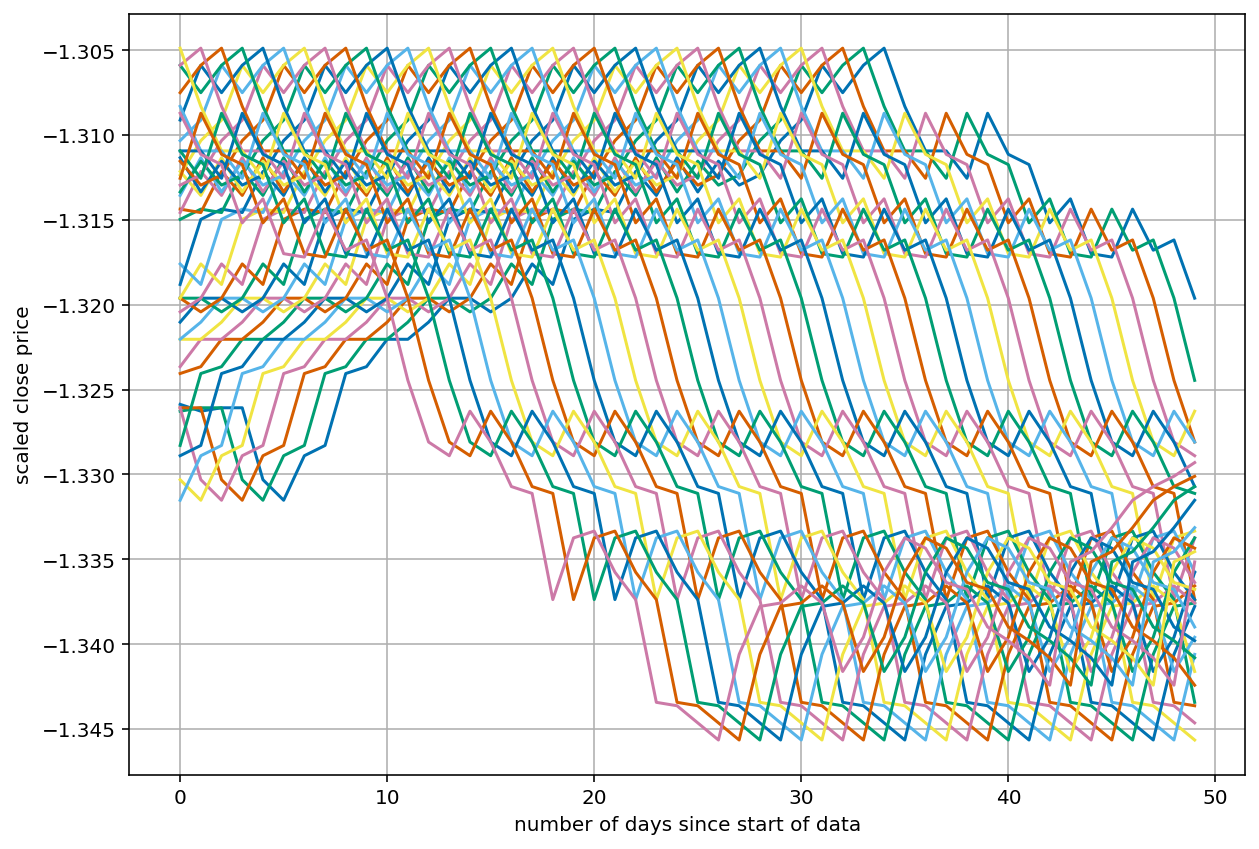

In [18]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(X_train[:50,:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.grid(True)
plt.show

In [19]:
# For now we are specifying the activation function to be relu, soon we will change it to test performance
model = Sequential([
    LSTM(64, activation = 'relu', return_sequences = True, input_dim = 11),
    LSTM(64, activation = 'relu', return_sequences = True),
    LSTM(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

In [20]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          19456     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 85,569
Trainable params: 85,569
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
269/269 [==============================] - 16s 45ms/step - loss: 0.0435 - mean_absolute_error: 0.0844
Epoch 2/15
269/269 [==============================] - 16s 61ms/step - loss: 0.0011 - mean_absolute_error: 0.0211
Epoch 3/15
269/269 [==============================] - 14s 52ms/step - loss: 9.7324e-04 - mean_absolute_error: 0.0201
Epoch 4/15
269/269 [==============================] - 12s 44ms/step - loss: 7.7056e-04 - mean_absolute_error: 0.0180
Epoch 5/15
269/269 [==============================] - 10s 37ms/step - loss: 6.7641e-04 - mean_absolute_error: 0.0171
Epoch 6/15
269/269 [==============================] - 9s 34ms/step - loss: 6.6788e-04 - mean_absolute_error: 0.0166
Epoch 7/15
269/269 [==============================] - 10s 37ms/step - loss: 4.4471e-04 - mean_absolute_error: 0.0138
Epoch 8/15
269/269 [==============================] - 8s 29ms/step - loss: 4.0748e-04 - mean_absolute_error: 0.0133
Epoch 9/15
269/269 [==============================] - 7s 27ms/step - loss:

In [23]:
len(history.history["loss"])

15

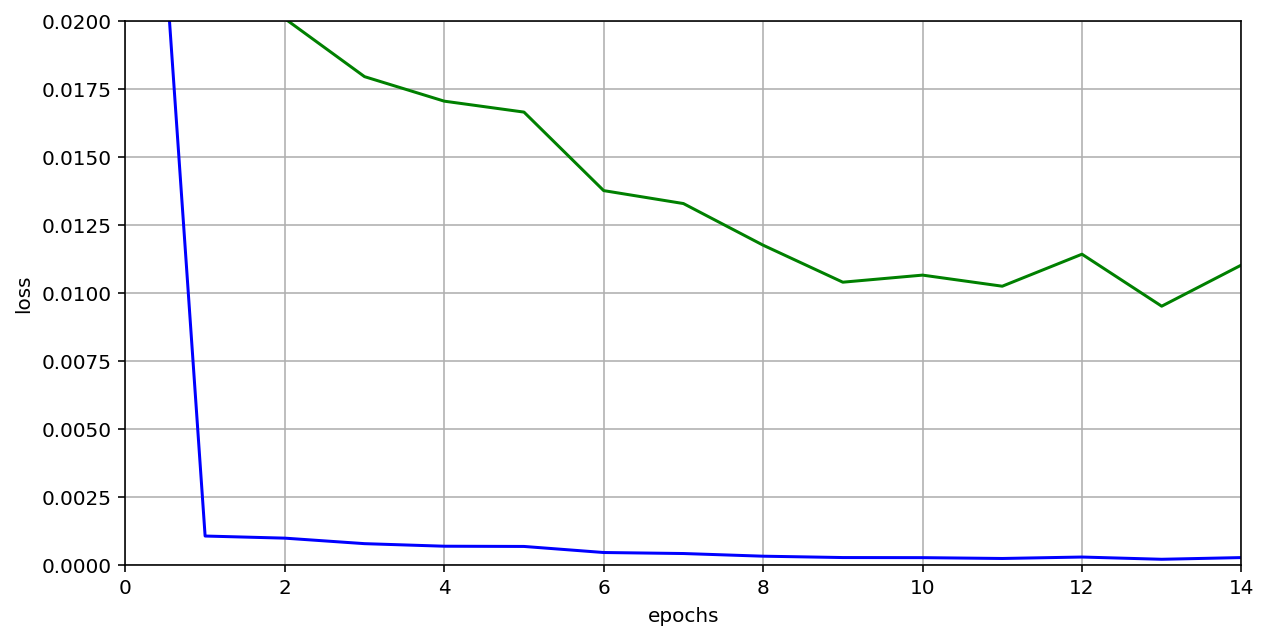

In [24]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"], c = 'b')
plt.plot(history.history['mean_absolute_error'], c = 'g')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0,0.02)
plt.xlim(0,14)
plt.grid(True)
plt.show()

In [25]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Test set loss:', loss)
print('Test set accuracy:', accuracy)

67/67 [==============================] - 1s 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0302
Test set loss: 0.0017877850914373994
Test set accuracy: 0.030240850523114204


In [26]:
# Prediction on the training set
y_train_pred = model.predict(X_train)

# Unscale the predicted values
y_train_pred_unscaled = scaler.inverse_transform(y_train_pred)

# Unscaled y_train
y_train_unscaled = scaler.inverse_transform(y_train)




# # create empty table with 13 fields (same number of columns)
# y_pred_dataset_like = np.zeros(shape=(len(y_pred), 12))

# # put the predicted values in the right field
# y_pred_dataset_like[:,0] = y_pred[:,0]
# # inverse transform and then select the right field
# y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

# y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

# print(y_pred.shape)

269/269 [==============================] - 3s 10ms/step


In [27]:
print(y_train_pred_unscaled.shape)
print(y_train_unscaled.shape)

(8600, 1)
(8600, 1)


In [28]:
# Unscaled the training set values
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 12))

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8600, 1)


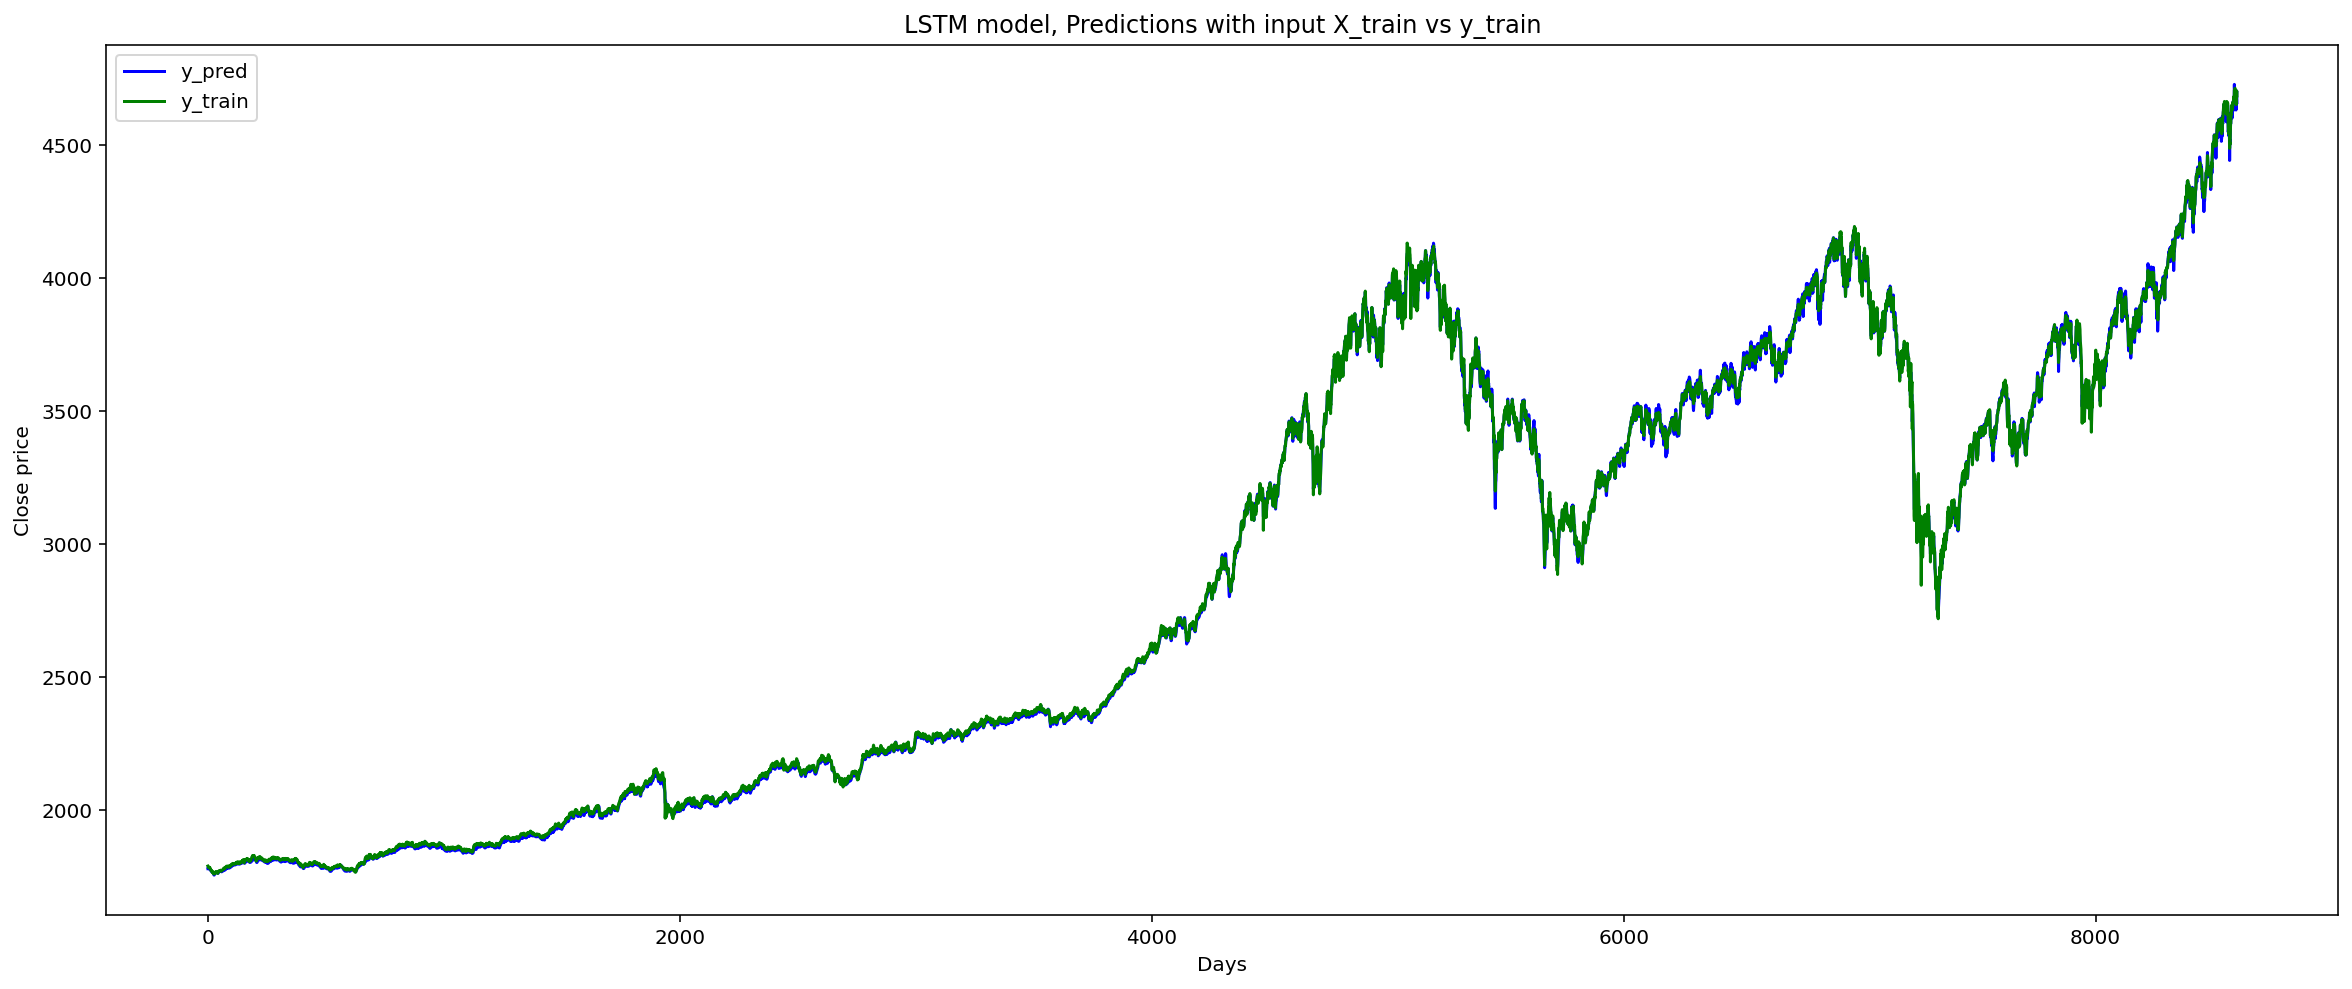

In [29]:
plt.figure(figsize = (20,8))
plt.plot(y_train_pred_unscaled, color = "b", label = "y_pred" )
plt.plot(y_train_unscaled, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [30]:
# Make a prediction on the test set
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

67/67 [==============================] - 1s 16ms/step


In [31]:
y_test_pred_unscaled = scaler.inverse_transform(y_pred_on_test)
y_test_unscaled = scaler.inverse_transform(y_test)

In [32]:
print(y_test_pred_unscaled.shape)
print(y_test_unscaled.shape)

(2120, 1)
(2120, 1)


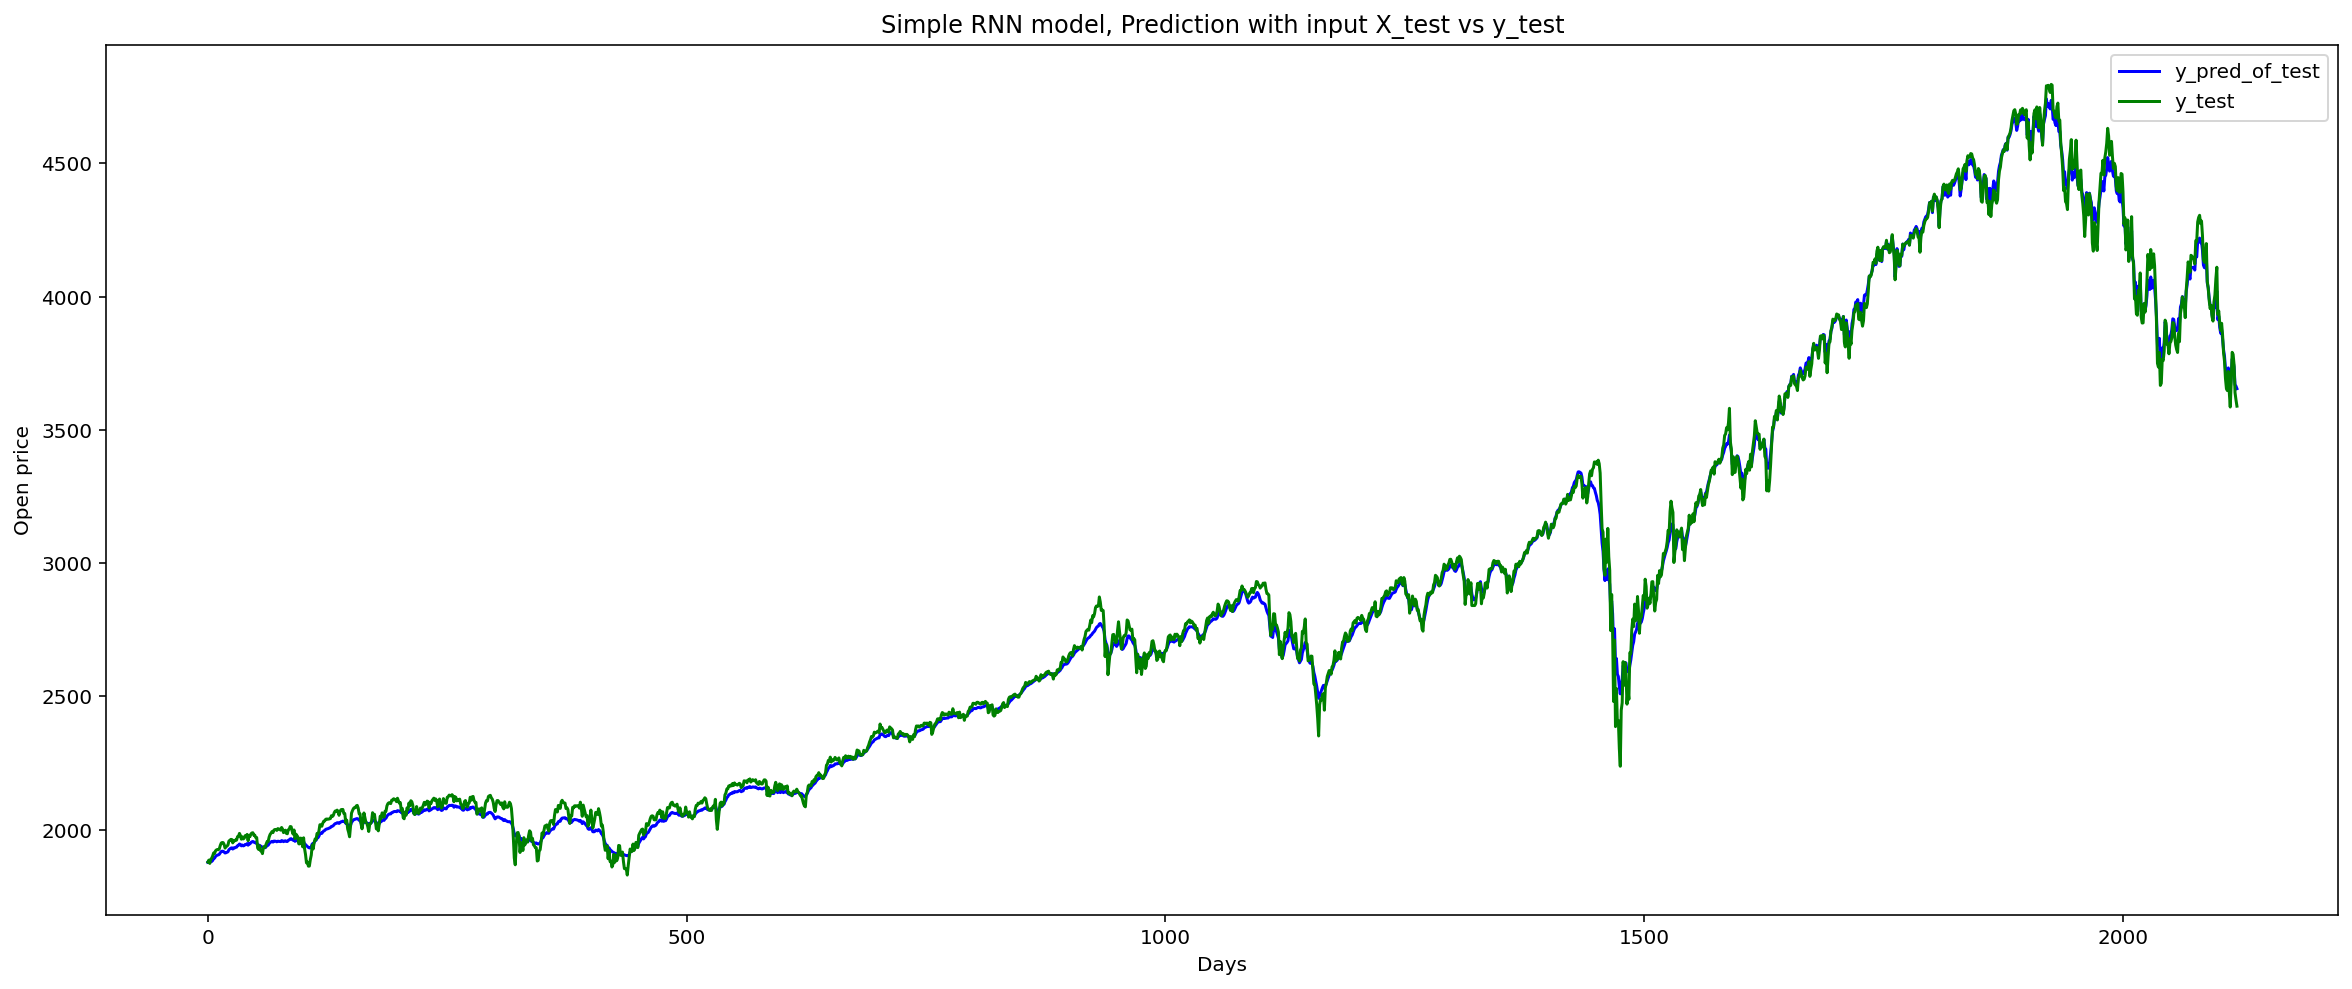

In [33]:
plt.figure(figsize = (20,8))
plt.plot(y_test_pred_unscaled, label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

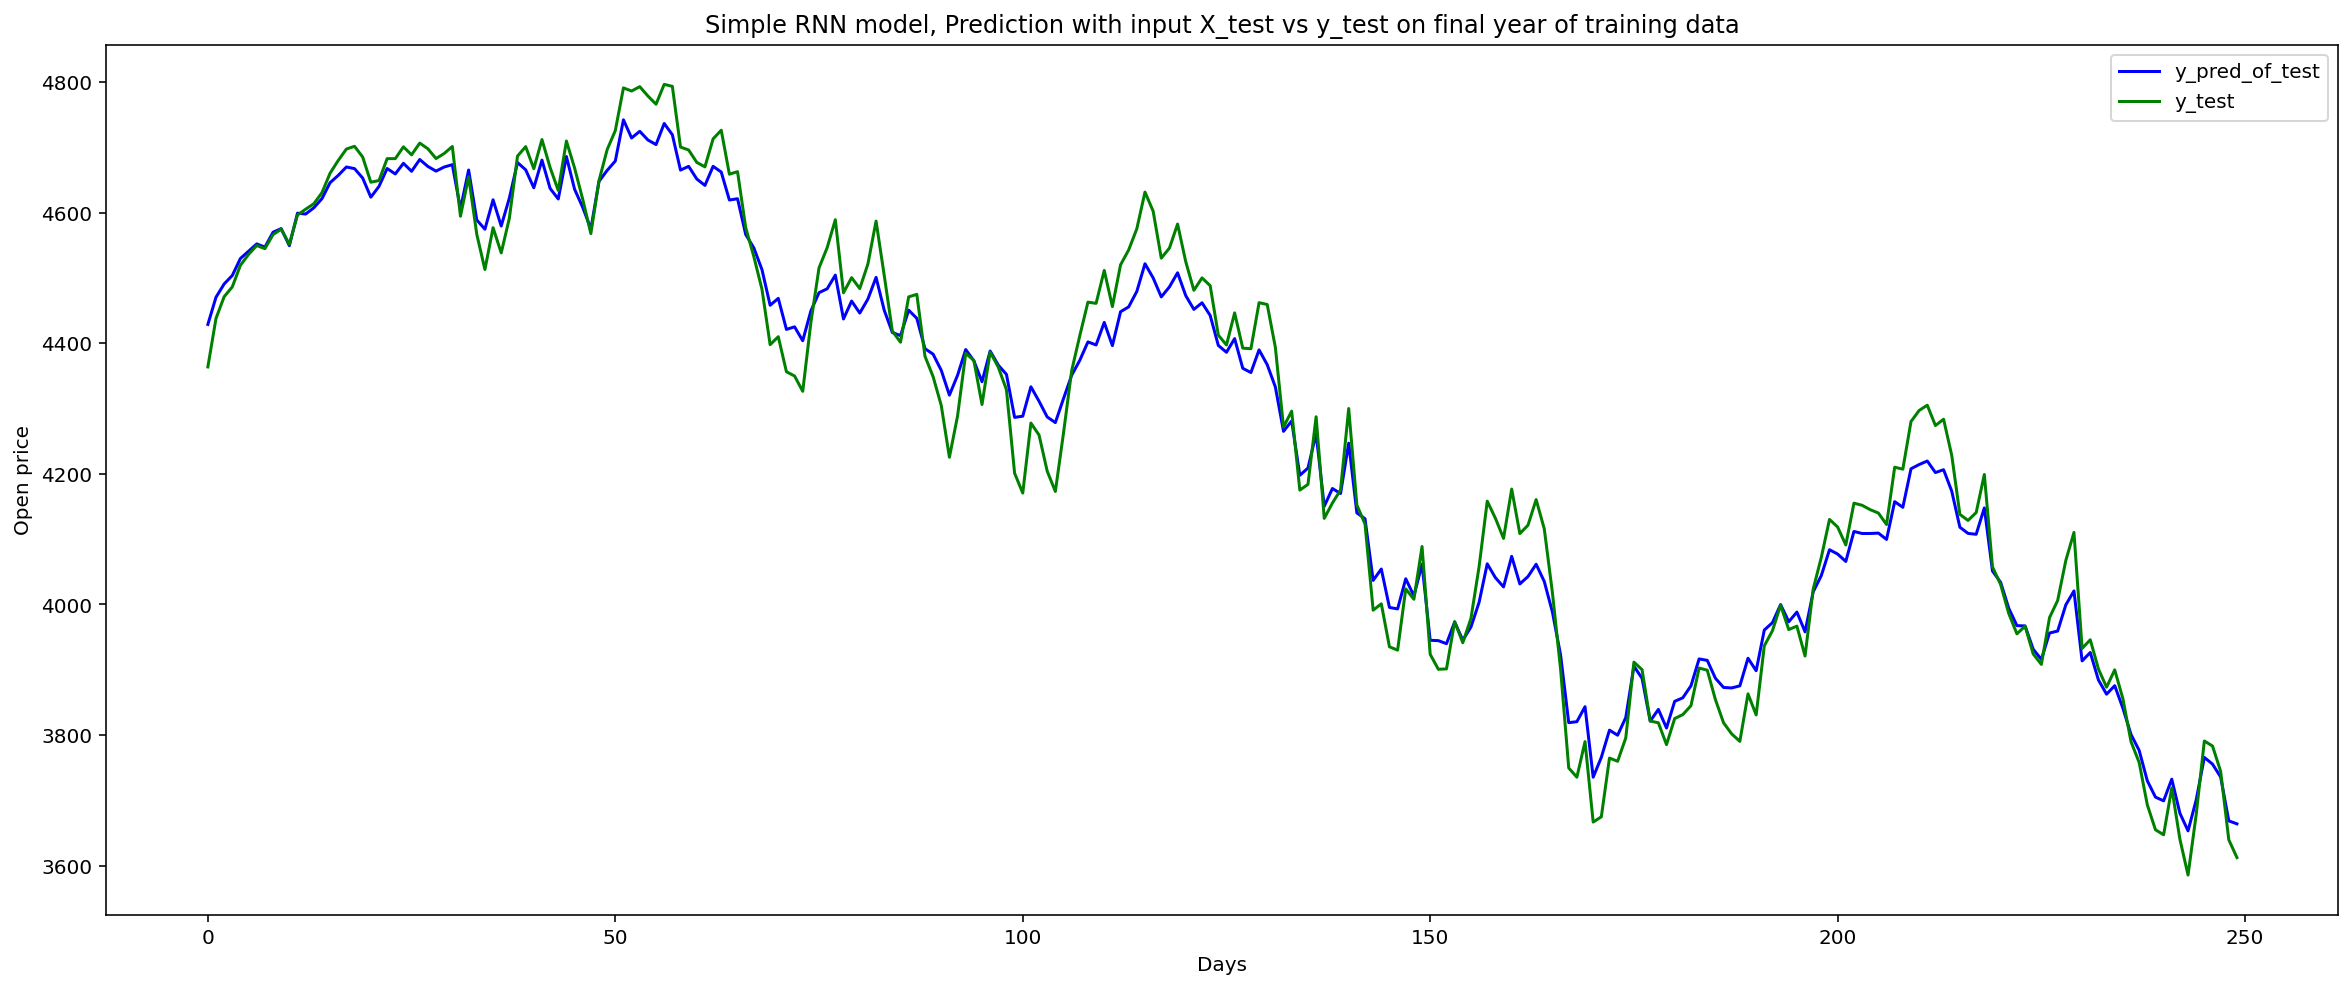

In [34]:
plt.figure(figsize = (20,8))
plt.plot(y_test_pred_unscaled[(2121 - 252):-1], label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled[(2121 - 252) : -1], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test on final year of training data")
plt.legend()
plt.show()

In [35]:
y_test.shape[0]/5

424.0

In [36]:
y_test_unscaled[(2121-422):].shape

(421, 1)

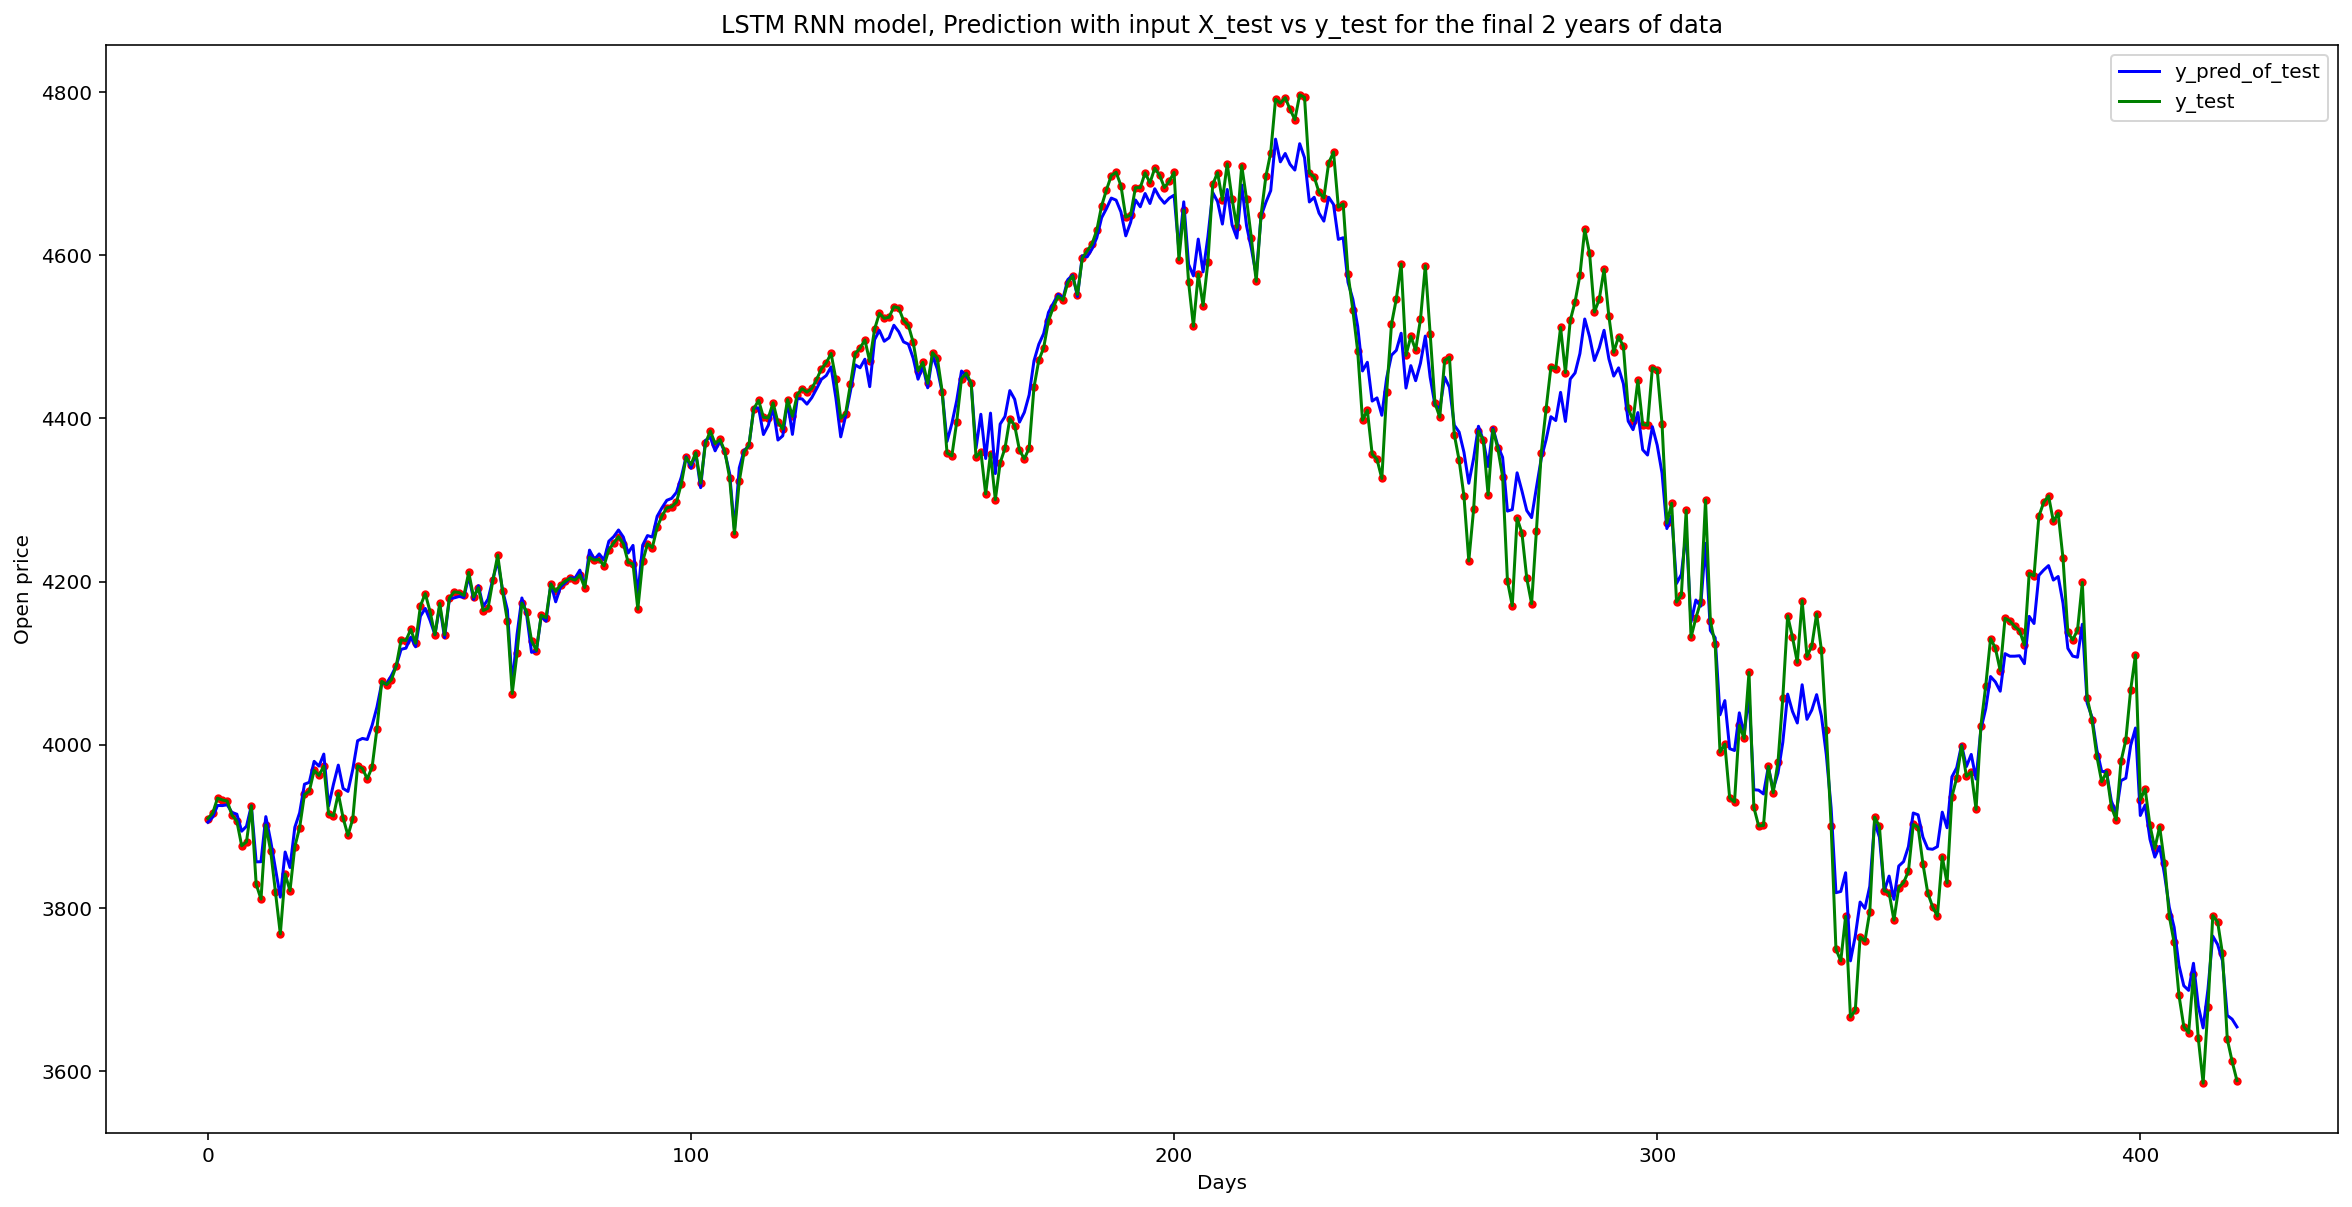

In [37]:
plt.figure(figsize = (20,10))
plt.plot(y_test_pred_unscaled[(2121-422):], label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled[(2121-422):], label = "y_test", c = "g")

x = np.arange(0,421,1)
plt.scatter(x, y_test_unscaled[(2121 - 422):], s = 10, c = 'red')

plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

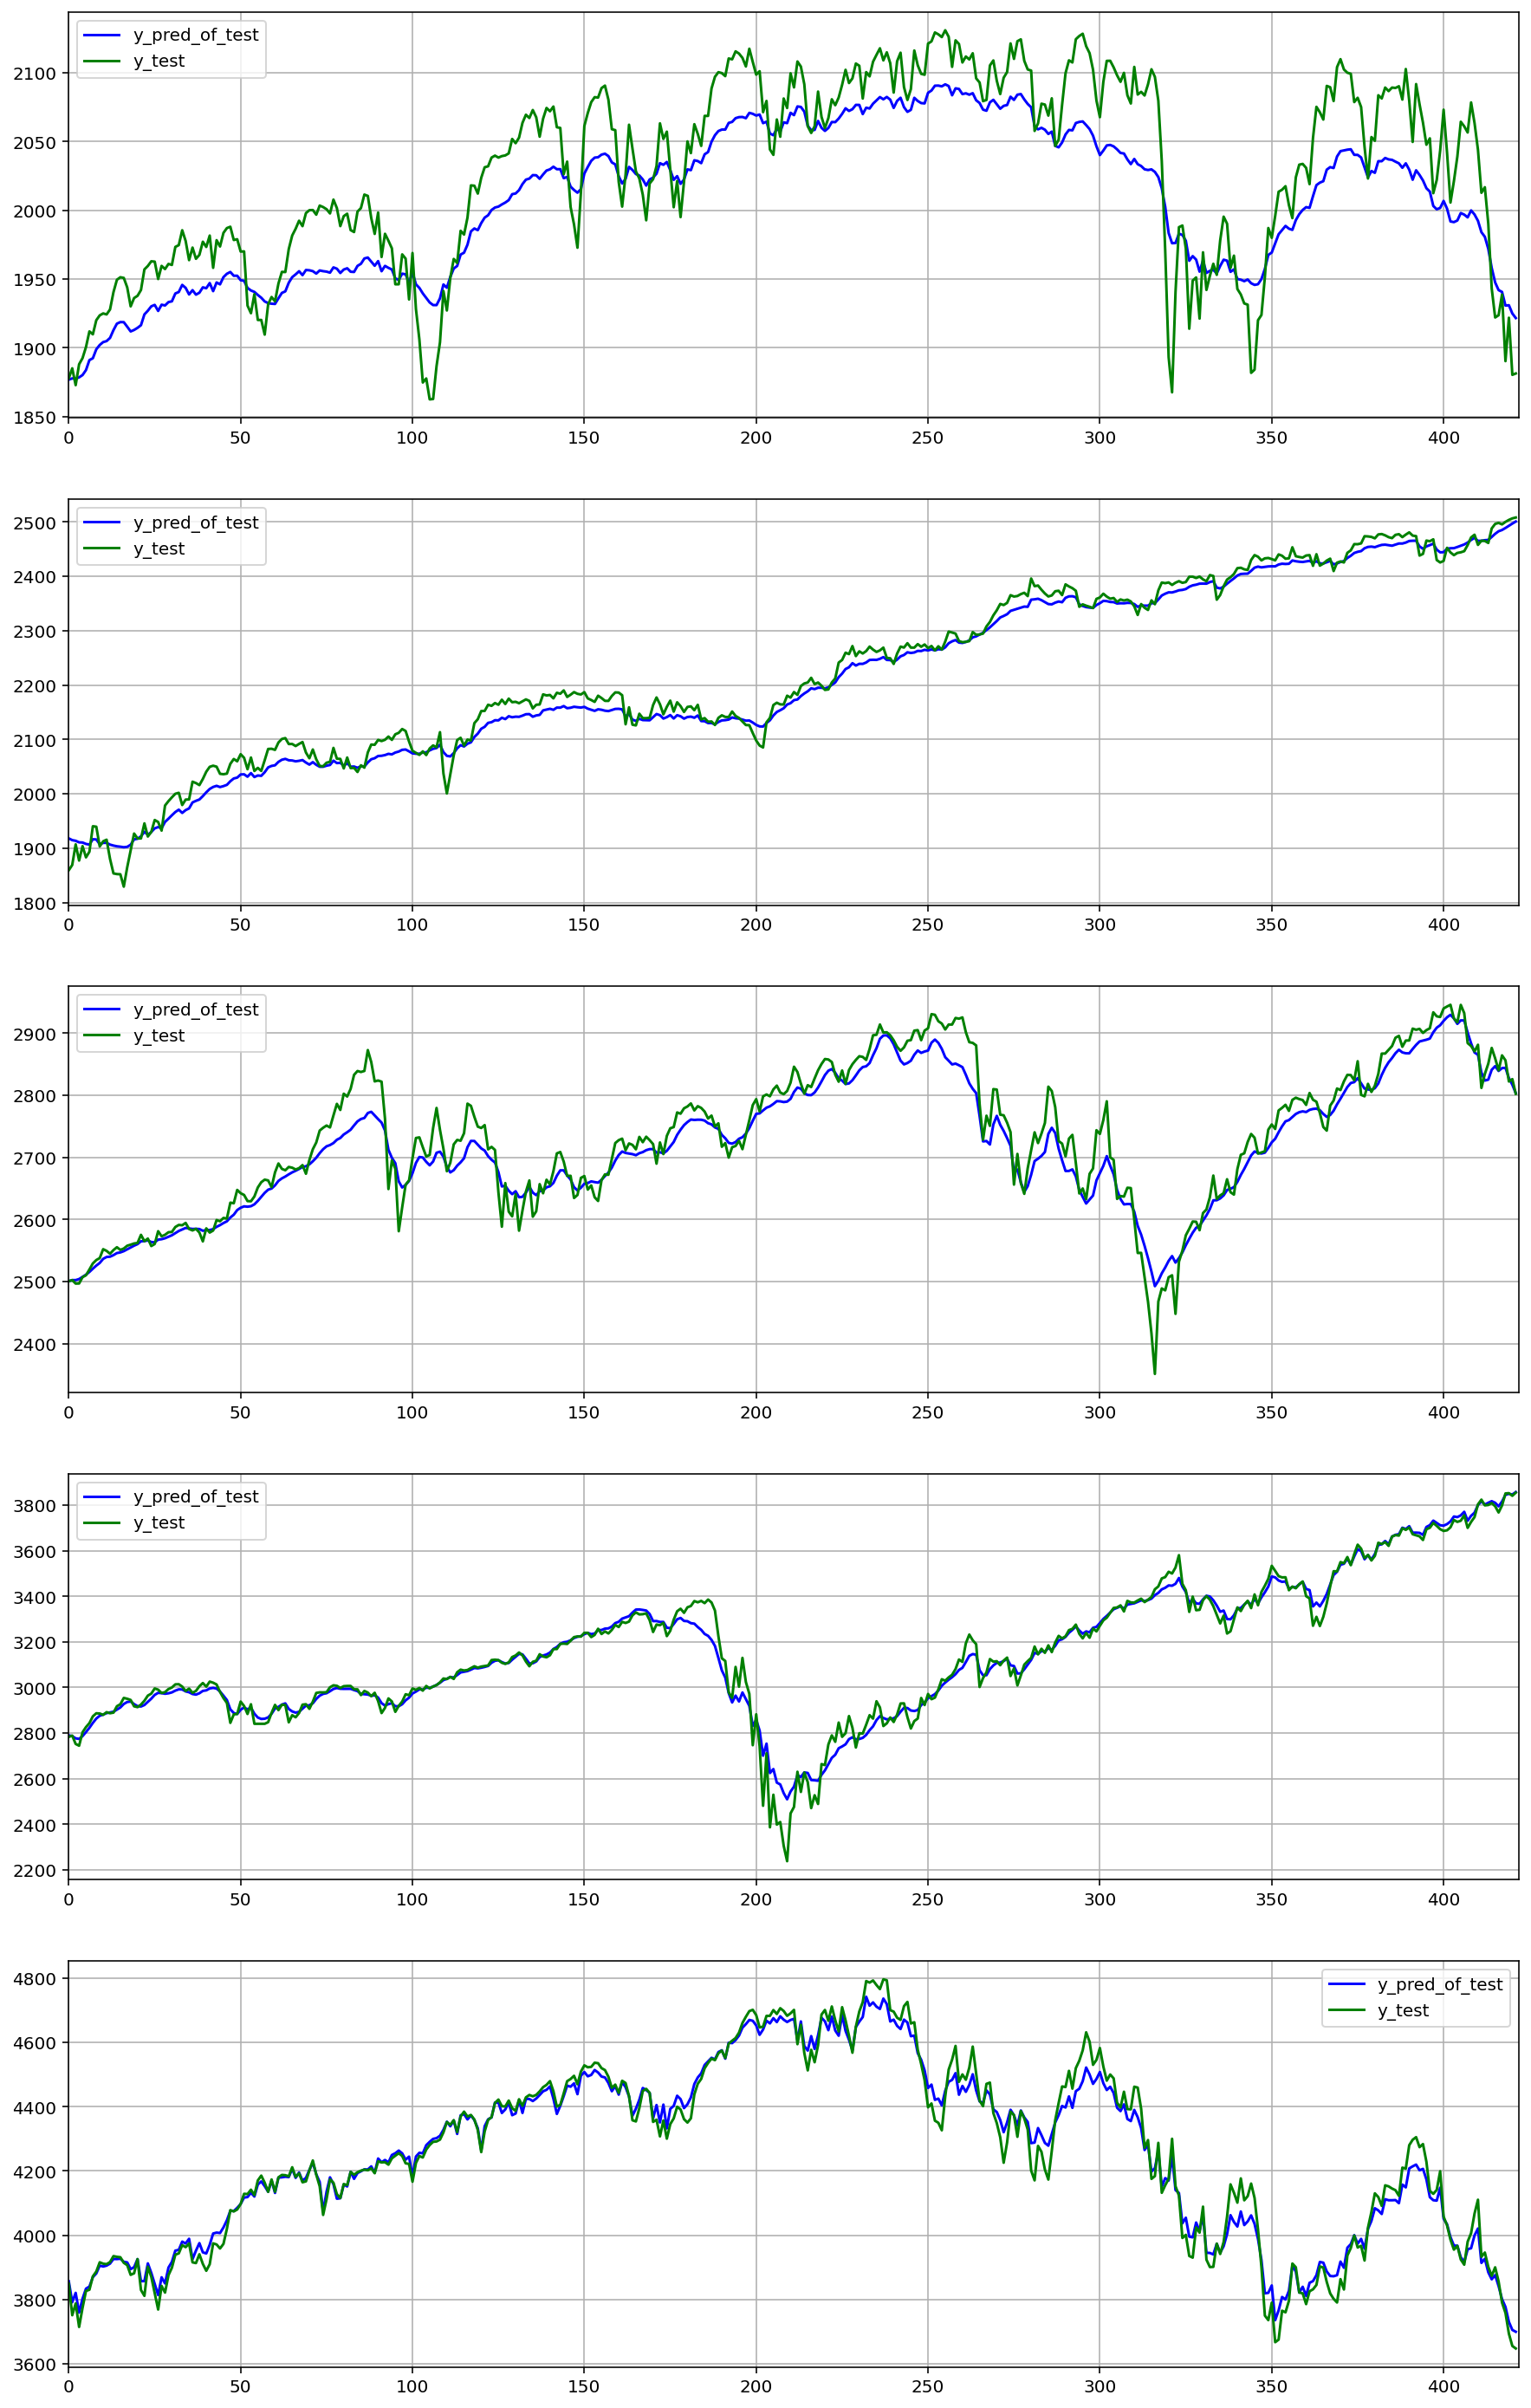

In [38]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_test_pred_unscaled[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test_unscaled[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])
    ax[i].legend()


In [87]:
# For now we are specifying the activation function to be relu, soon we will change it to test performance
gru = Sequential([
    GRU(64, activation = 'relu', return_sequences = True, input_dim = 11),
    GRU(64, activation = 'relu', return_sequences = True),
    GRU(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

In [88]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

gru.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [89]:
history = gru.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
269/269 [==============================] - 10s 27ms/step - loss: 1806245.2500 - mean_absolute_error: 688.8339
Epoch 2/15
269/269 [==============================] - 7s 27ms/step - loss: 2085.4709 - mean_absolute_error: 32.6765
Epoch 3/15
269/269 [==============================] - 7s 25ms/step - loss: 1617.6208 - mean_absolute_error: 28.5310
Epoch 4/15
269/269 [==============================] - 7s 26ms/step - loss: 1519.6006 - mean_absolute_error: 27.7667
Epoch 5/15
269/269 [==============================] - 7s 26ms/step - loss: 1590.6450 - mean_absolute_error: 28.7022
Epoch 6/15
269/269 [==============================] - 7s 26ms/step - loss: 1327.6740 - mean_absolute_error: 26.0728
Epoch 7/15
269/269 [==============================] - 8s 29ms/step - loss: 1342.4023 - mean_absolute_error: 26.1655
Epoch 8/15
269/269 [==============================] - 8s 28ms/step - loss: 1401.2950 - mean_absolute_error: 26.6934
Epoch 9/15
213/269 [======================>.......] - ETA: 1s - los

KeyboardInterrupt: 

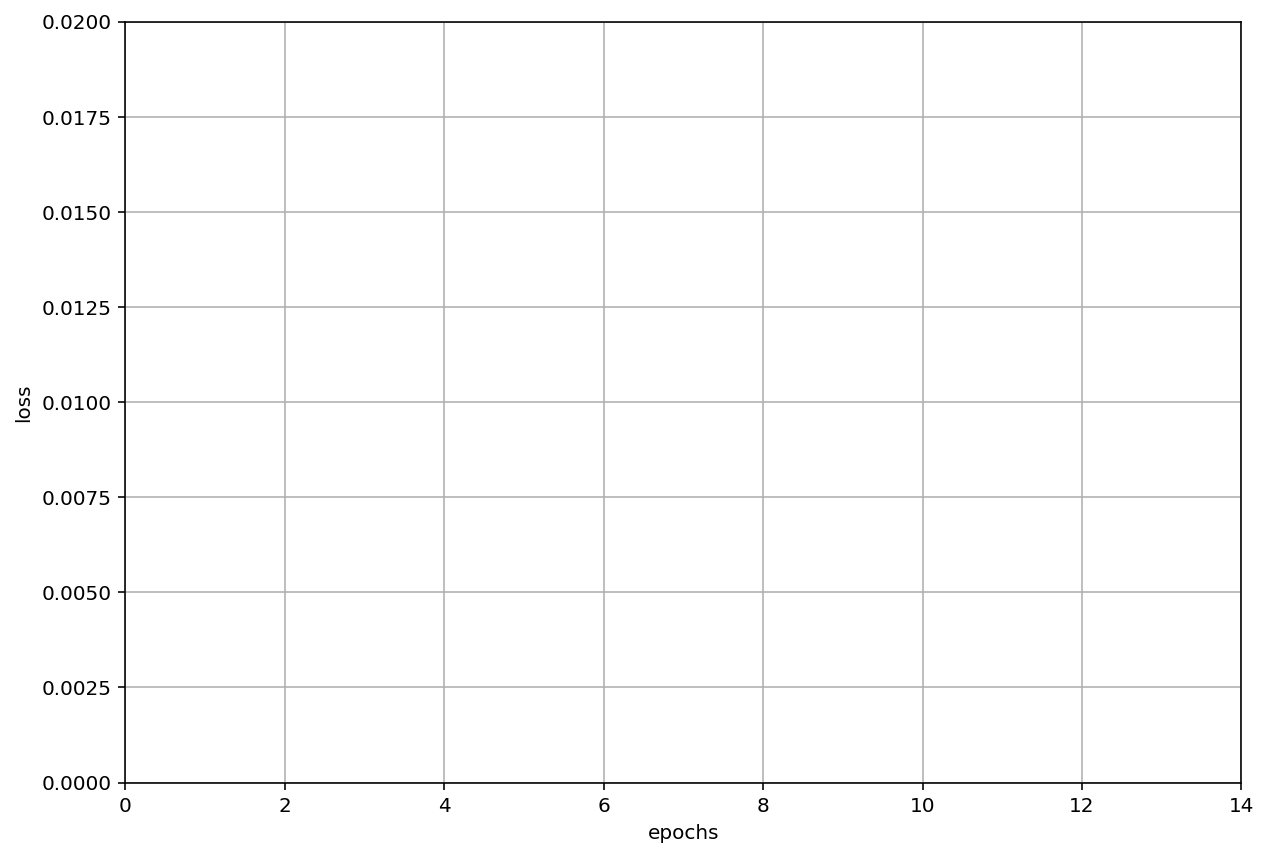

In [37]:
plt.figure(figsize = (10,7))
plt.plot(history.history["loss"], c = 'b')
plt.plot(history.history['mean_absolute_error'], c = 'g')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0,0.02)
plt.xlim(0,14)
plt.grid(True)
plt.show()

In [38]:
loss, accuracy = gru.evaluate(X_test, y_test)

print('Test set loss:', loss)
print('Test set accuracy:', accuracy)

67/67 [==============================] - 1s 9ms/step - loss: 9079670.0000 - mean_absolute_error: 2899.6804
Test set loss: 9079670.0
Test set accuracy: 2899.680419921875


In [39]:
# Make a prediction on the test set
y_pred_on_test = gru.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

67/67 [==============================] - 1s 8ms/step


In [40]:
y_test_pred_unscaled = scaler.inverse_transform(y_pred_on_test)
y_test_unscaled = scaler.inverse_transform(y_test)

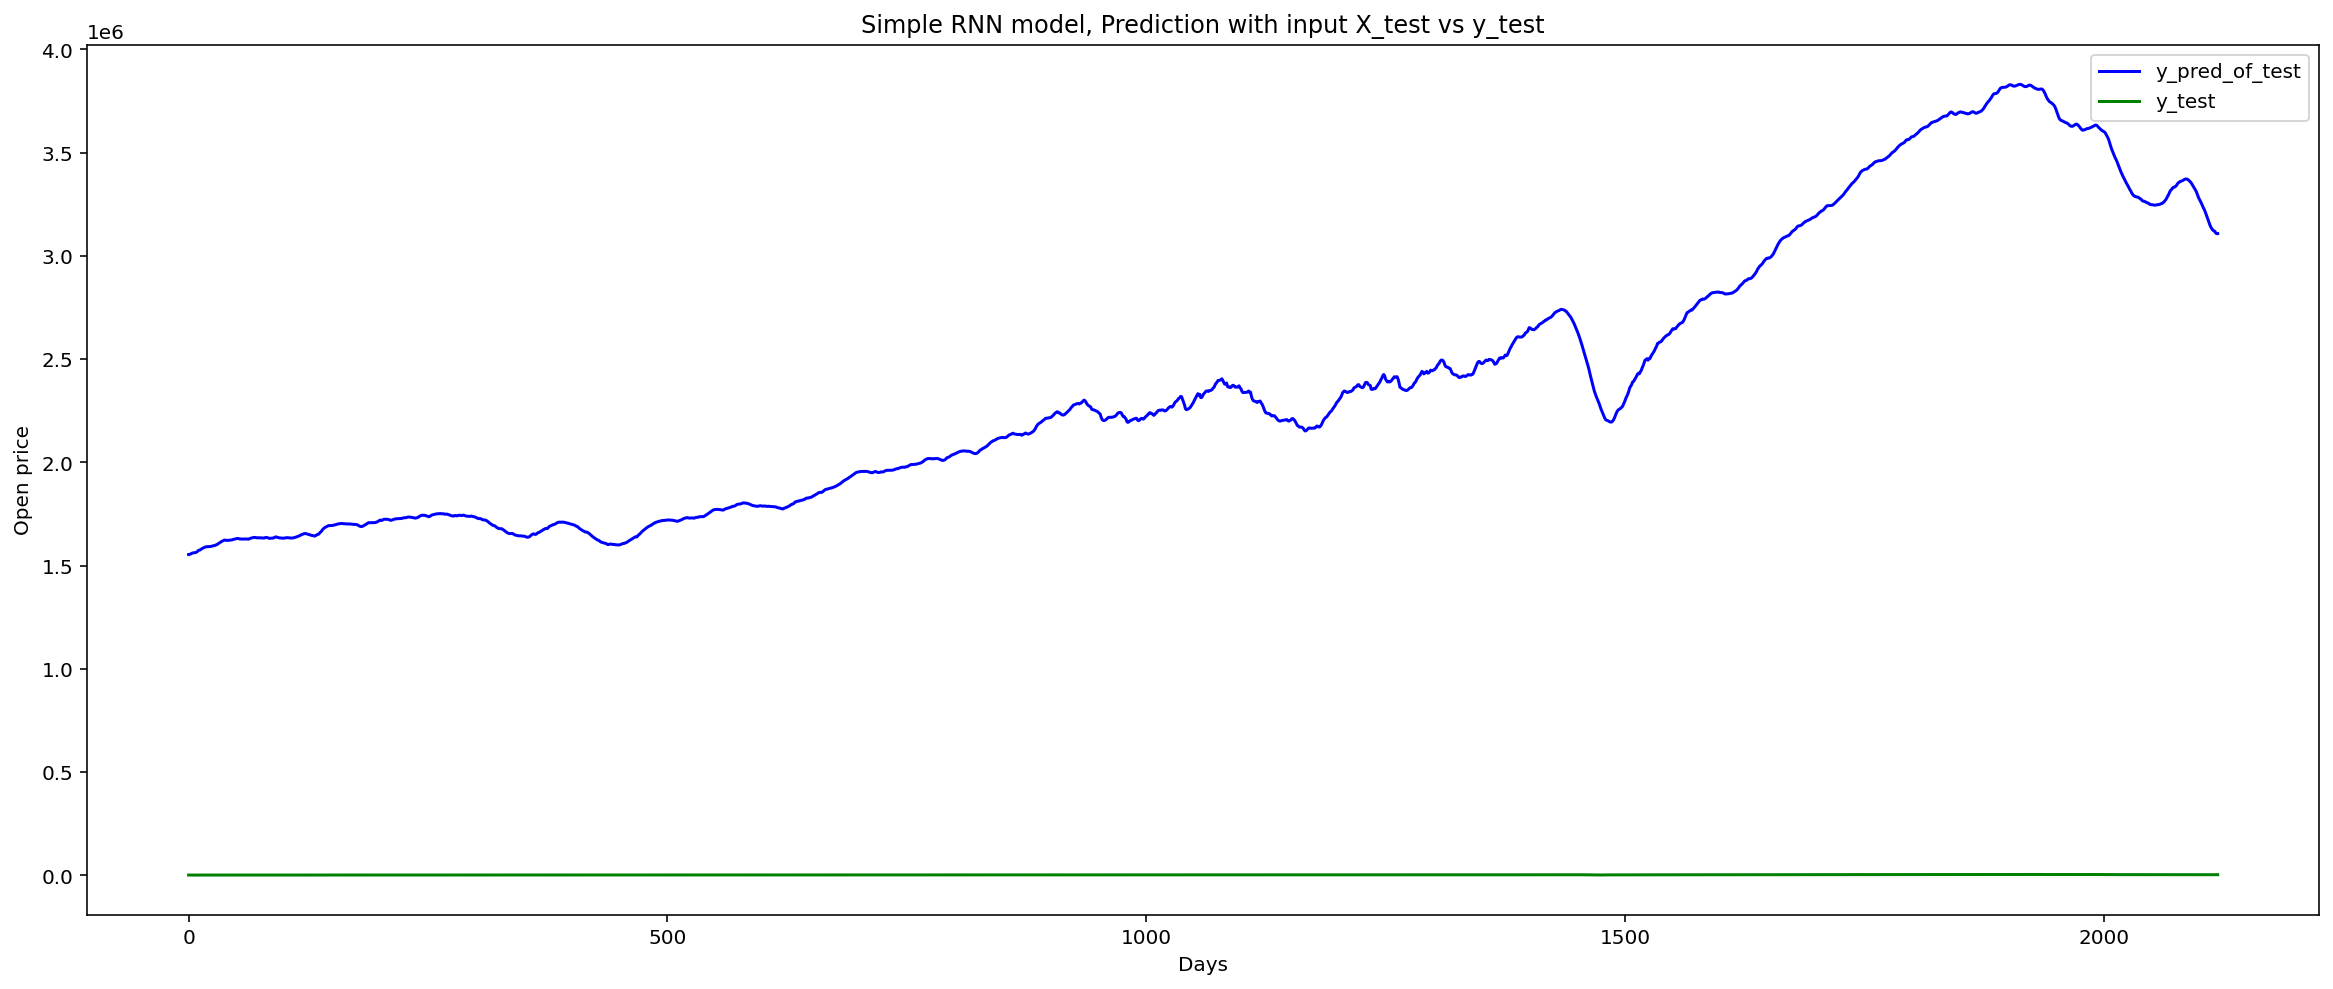

In [41]:
plt.figure(figsize = (20,8))
plt.plot(y_test_pred_unscaled, label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

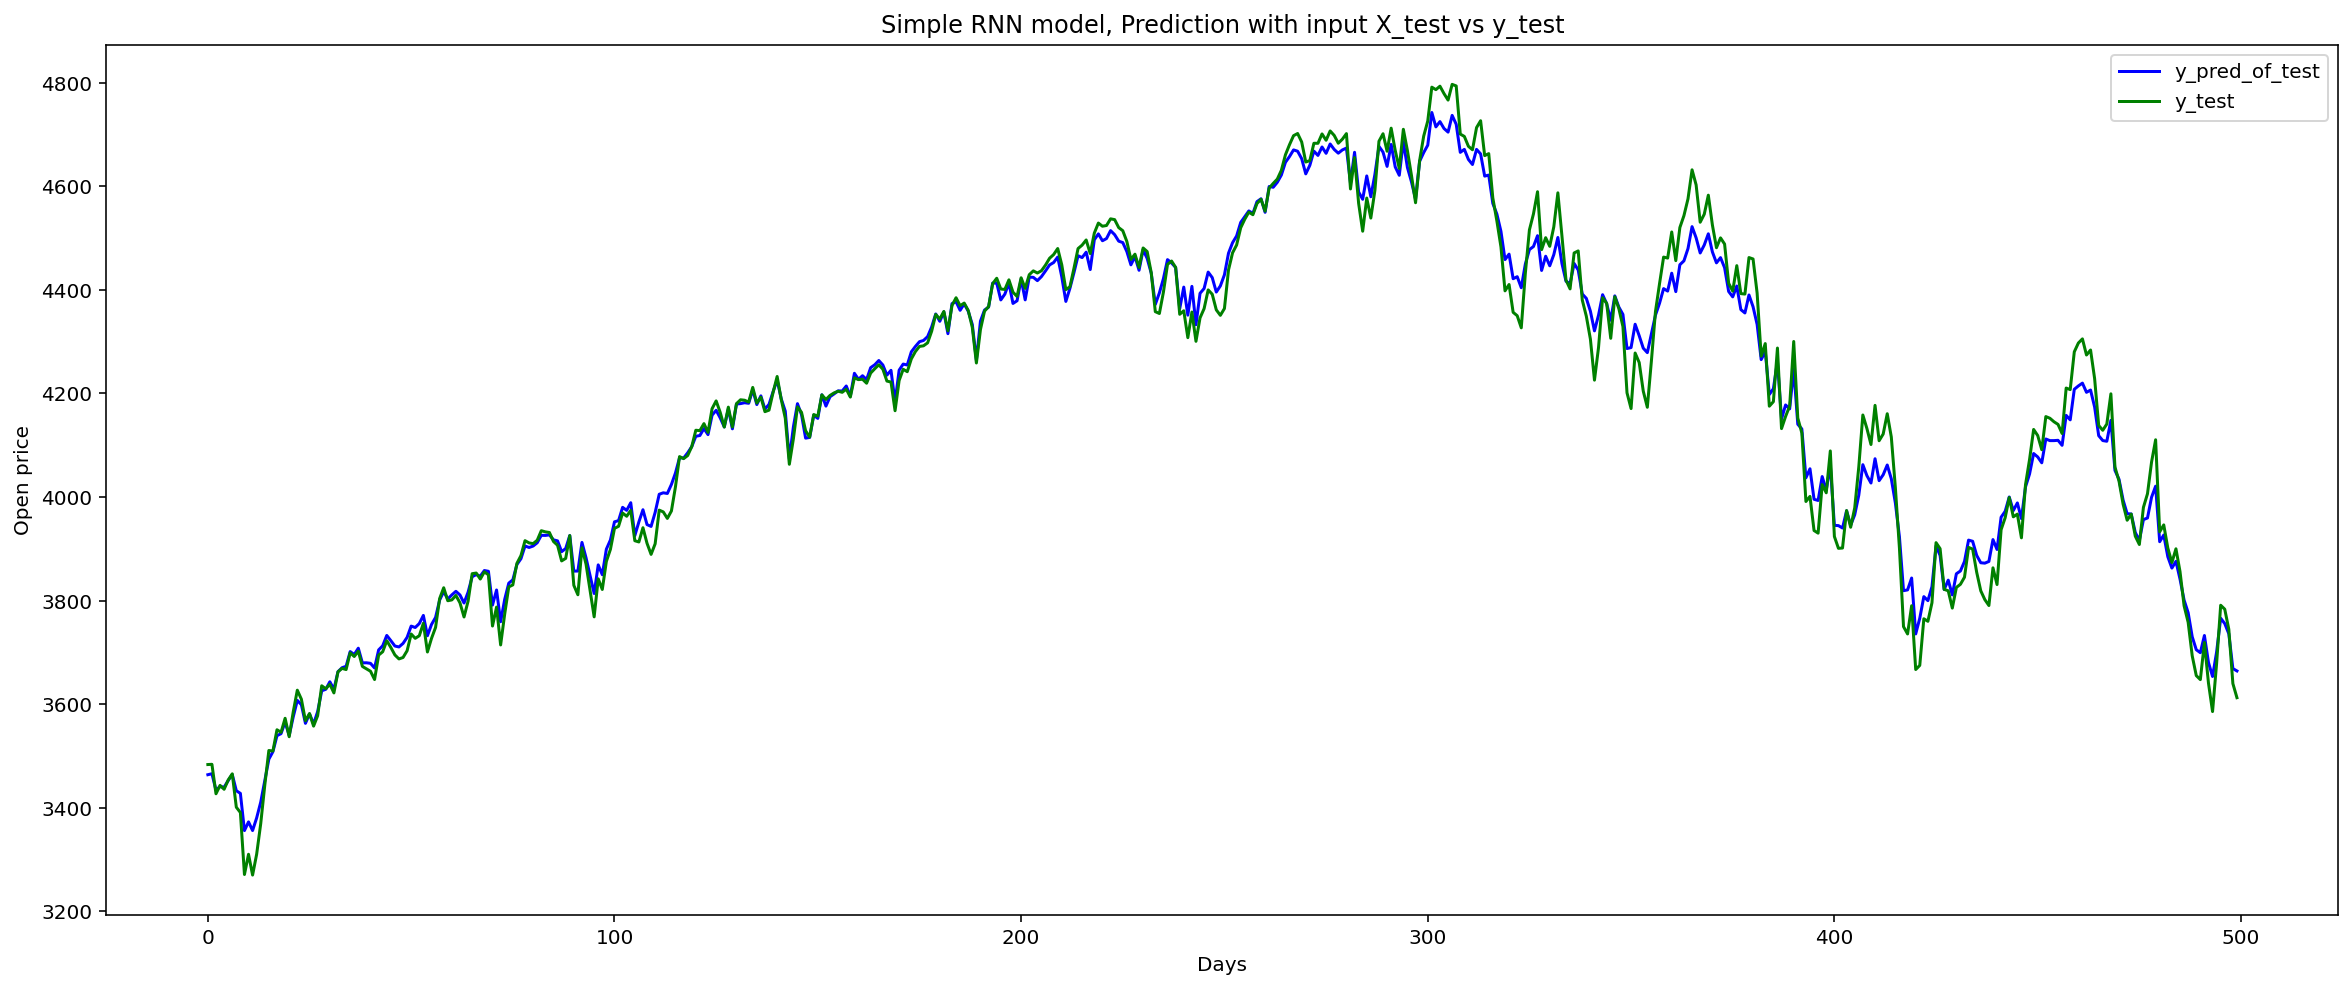

In [133]:
plt.figure(figsize = (20,8))
plt.plot(y_test_pred_unscaled[(2121 - 502):-1], label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled[(2121 - 502) : -1], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [63]:
y_test_pred_unscaled = y_test_pred_unscaled.reshape(-1)

In [64]:
y_test_pred_unscaled.shape

(2121,)

In [65]:
y_test_unscaled = y_test_unscaled.reshape(-1)

In [66]:
d = {'predictions': y_test_pred_unscaled, 'close': y_test_unscaled}

In [74]:
testing_df = pd.DataFrame(d)

In [88]:
testing_df['predictions'] = testing_df['predictions'].shift(-1)

In [76]:
testing_df.head()

,predictions,close
0,1877.815552,1870.85
1,1882.012207,1877.86
2,1876.214478,1885.08
3,1882.174438,1872.83
4,1886.128052,1888.03


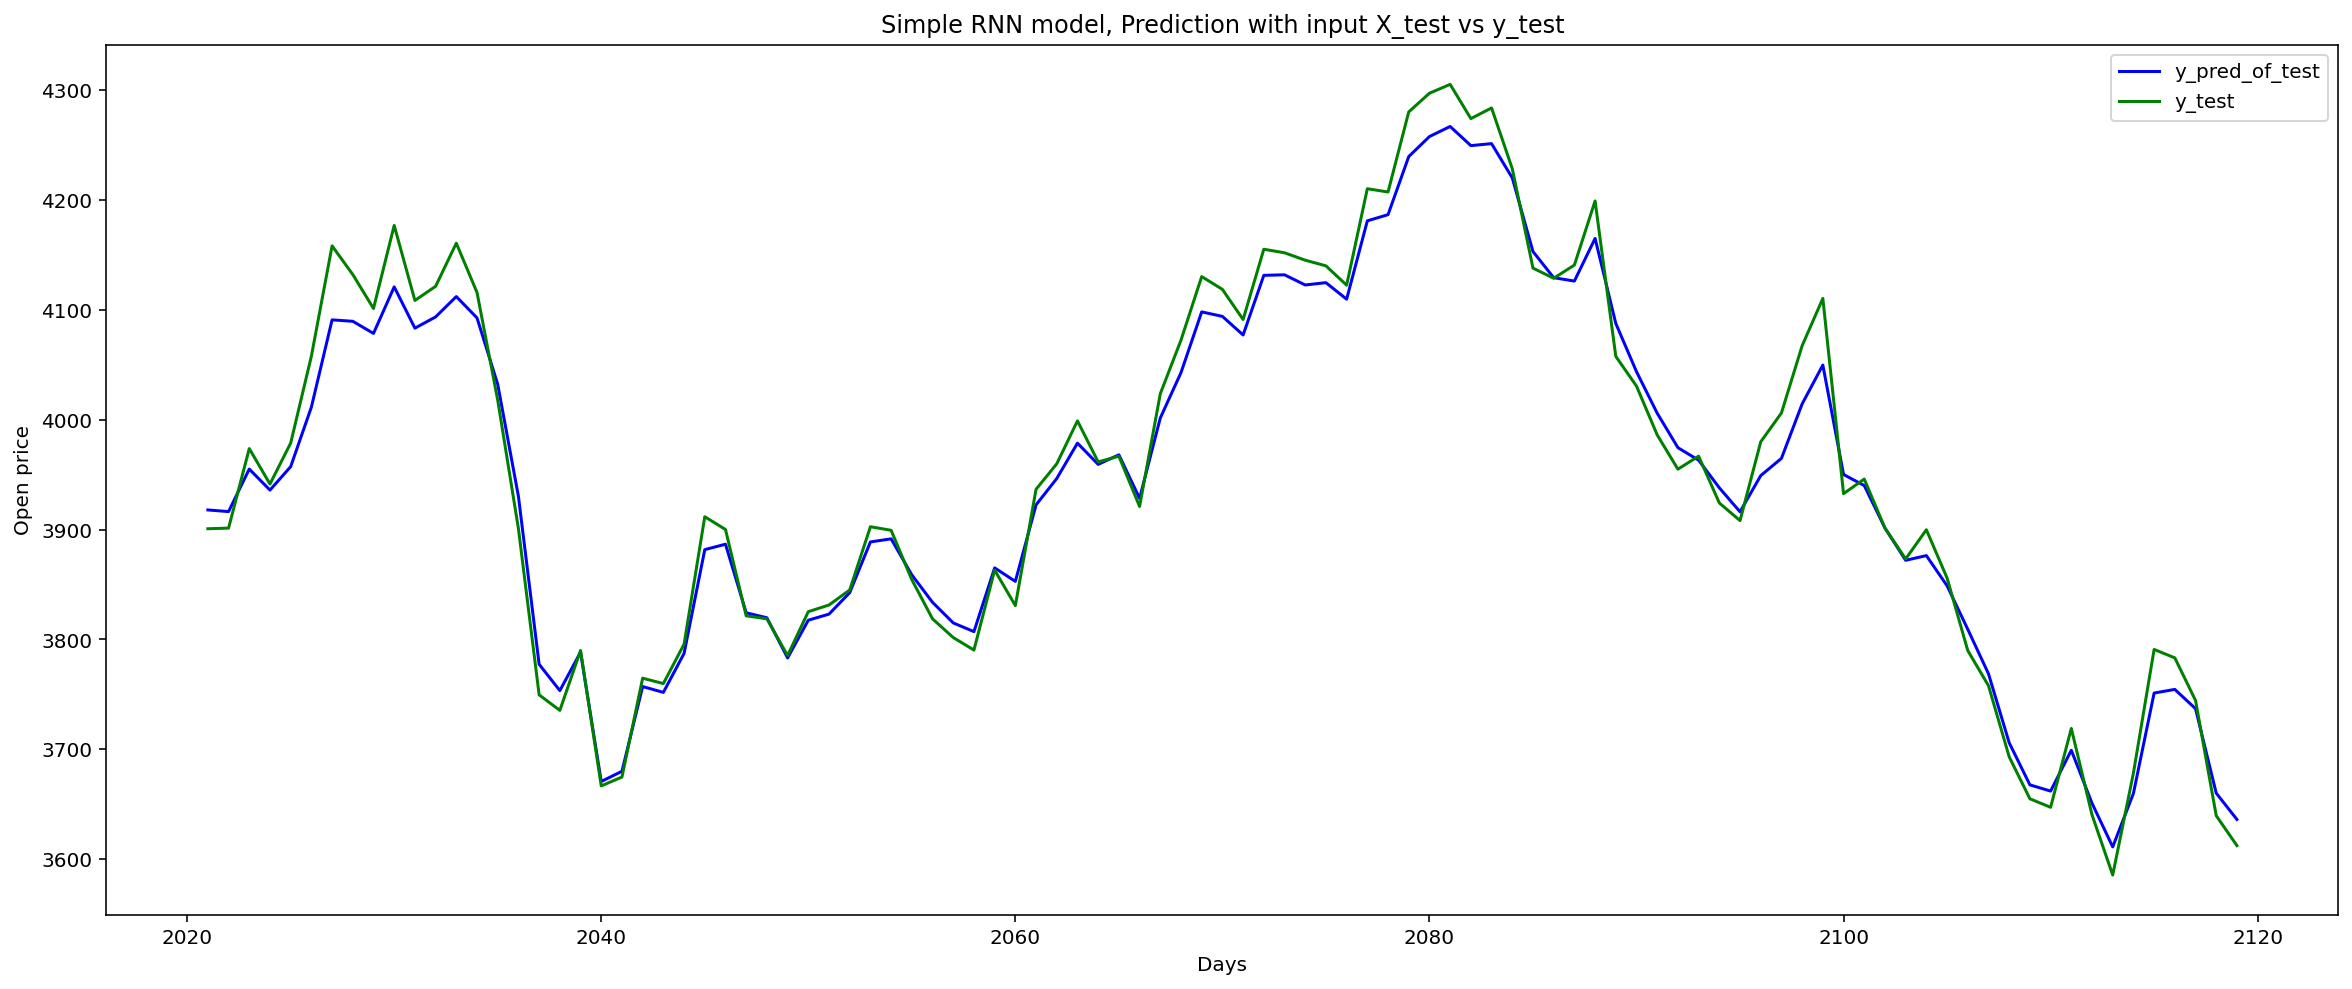

In [91]:
plt.figure(figsize = (20,8))
plt.plot(testing_df['predictions'][(2121 - 100):-1], label = "y_pred_of_test", c = "blue")
plt.plot(testing_df['close'][(2121 - 100) : -1], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

# Testing strategy

In the following functions we will apply the following strategy,

if we are not holding:

&emsp;if the predicted price is lower than the current price:

&emsp; &emsp; do nothing

&emsp; if the predicted price is higher than the current price:
        
&emsp;&emsp; then we buy with the entire amount that we have, at the open price of the market

if we are holding:

&emsp; if the predicted price is lower than the current price:

&emsp;&emsp; sell all that we have at the open price of the market
    
&emsp; if the predicted price is higher than the current price:

&emsp;&emsp; Do nothing

In [141]:
def strat2_set_signal(dataframe):
    
    # Condition to check if we are holding
    condition_1 = dataframe['signal'].shift(-1) > 0
    # Condition to check if we are not holding
    condition_2 = dataframe['signal'].shift(-1) < 0
    
    # Condition to check if the predicted price is higher than the current price
    condition_3 = dataframe['predictions'] > dataframe['close'].shift(-1)
    # Condition to check if the predicted price is lower than the current price
    condition_4 = dataframe['predictions'] < dataframe['close'].shift(-1)
    
    dataframe['buy sell signal'] = np.where(
        condition_1 & condition_3, 1, # Keep holding
        np.where(
            condition_1 & condition_4, -1, # Sell all
            np.where(
                condition_2 & condition_3, 2, # Buy
                np.where(
                    condition_2 & condition_3, 0, # Do nothing, n.b. do nothing is the same as keep holding
                    -5 # Default value
                )
            )
        )
    )
        
    return dataframe


def strat2_returns(dataframe):
    
    dataframe['strat2 returns'] = None
    
    dataframe['strat2 returns'] = np.where(
        dataframe['buy sell signal'] = 1, # Calc the diff between here and previous close # Keep holding
        np.where(
            dataframe['buy sell signal'] = -1, # Sell everything
            np.where(
                dataframe['buy sell signal'] = 2, # Buy everything
                np.where(
                    dataframe['buy sell signal'] = 0, # Do nothing
                    -7 # Default
                )
            )
        )
    )
    
    return dataframe

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (1172328484.py, line 35)

We will actually be using the following strategy,

if the predicted price is higher than yesterdays close price:

&emsp; buy all with everything we have at open

&emsp; sell everything at the end of the day

elif predicted price for tomorrow is lower than it is today:

&emsp; Do nothing

In [101]:
actual_df = df_test[['close', 'open']]
actual_df.shape

(2161, 2)

In [105]:
type(y_test_pred_unscaled)

numpy.ndarray

In [110]:
pred_df = pd.DataFrame(y_test_pred_unscaled, columns = ['predictions'])

In [111]:
pred_df.head()

,predictions
0,1874.028931
1,1877.815552
2,1882.012207
3,1876.214478
4,1882.174438


In [125]:
# Create dataframe
def create_df(predictions, original):
    # Create a separate dataframe for the original data
    actual_df = original[['close', 'open']][time_step:]
    
    # Create a separate dataframe for the prediction data
    # Our prediction input will be a numpy array
    pred_df = pd.DataFrame(predictions, columns = ['predictions'])
    
    pred_df = pred_df['predictions'].shift(-1)
    
    if (pred_df.shape[0] == actual_df.shape[0]):
        length = pred_df.shape[0]
        pred_df['index'] = range(0, length)
        actual_df['index'] = range(0, length)
    else:
        print('Double check the input shapes of both dataframes, lengths do not match')
        
    # Merge the two dataframes
    merge_df = actual_df.join(pred_df, on = 'index', lsuffix = '_actual', rsuffix = '_prediction')
    merge_df = merge_df[['close', 'predictions', 'open']]
    
    return merge_df


# This function will create the signal 
def set_signal(dataframe):
    # Create empty column
    dataframe['signal'] = None
    dataframe['signal'] = np.where(
        dataframe['predictions'] - dataframe['open'] > 0, 1, -1
    )
    
    return dataframe


# This function will apply the strategy to our dataframe and track the progress
def strategy(dataframe):
    dataframe['strat returns'] = None
    
    # if the signal is greater than zero 
    # Track returns using the strategy when signal is positive, otherwise set to zero
    dataframe['strat returns'] = np.where(
        dataframe['signal'] > 0, dataframe['close'] - dataframe['open'], 0
    )
    
    # Track the percent change when the signal is positive
    dataframe['strat percent change'] = np.where(
        dataframe['signal'] > 0, ((dataframe['close'] - dataframe['open']) / dataframe['open']) * 100, 0
    )
    
    return dataframe


def strat_results(dataframe):
    dataframe['strat cumulative'] = dataframe['strat percent change'].cumsum()
    
    return dataframe


def buy_and_hold_results(dataframe):
    value = merged_df['open'].iloc[0]
    dataframe['buy and hold percent change'] = ((dataframe['close'] - value) / value) * 100
    dataframe['buy and hold cumulative'] = dataframe['buy and hold percent change'].cumsum()
    
    return dataframe


# def results(dataframe):
#     dataframe['strat cumsum'] = dataframe['strat returns'].cumsum()
#     dataframe['strat percent change'] = ((dataframe['strat cumsum'] - dataframe['strat cumsum'].shift(1)))
#     dataframe['strat cumulative'] = dataframe['strat percent change'].cumsum()
#     # dataframe['buy and hold relative change'] = (dataframe['close'] / dataframe['close'].shift(-1)) * 100
#     # dataframe['buy and hold cumulative'] = dataframe['buy and hold relative change'].cumsum()
    
#     return dataframe

Strategy 2:

condition only on the predicted price, and not the close price

In [127]:
merged_df = create_df(y_test_pred_unscaled, df_test)
merged_df = set_signal(merged_df)
merged_df = strategy(merged_df)

In [128]:
merged_df = strat_results(merged_df)
merged_df = buy_and_hold_results(merged_df)

In [129]:
merged_df.tail()

,close,predictions,open,signal,strat returns,strat percent change,strat cumulative,buy and hold percent change,buy and hold cumulative
Date,,,,,,,,,
2022-10-06,3744.52,3735.813232,3771.97,-1,0.00,0.000000,275.654660,99.531082,113396.054693
2022-10-07,3639.66,3668.636475,3706.74,-1,0.00,0.000000,275.654660,93.943495,113489.998188
2022-10-10,3612.39,3664.062012,3647.51,1,-35.12,-0.962849,274.691812,92.490382,113582.488570
2022-10-11,3588.84,3654.573975,3595.86,1,-7.02,-0.195225,274.496587,91.235493,113673.724063
2022-10-12,3577.03,NaN,3590.83,-1,0.00,0.000000,274.496587,90.606183,113764.330246


In [130]:
value = merged_df['open'].iloc[0]

In [131]:
value

1876.66

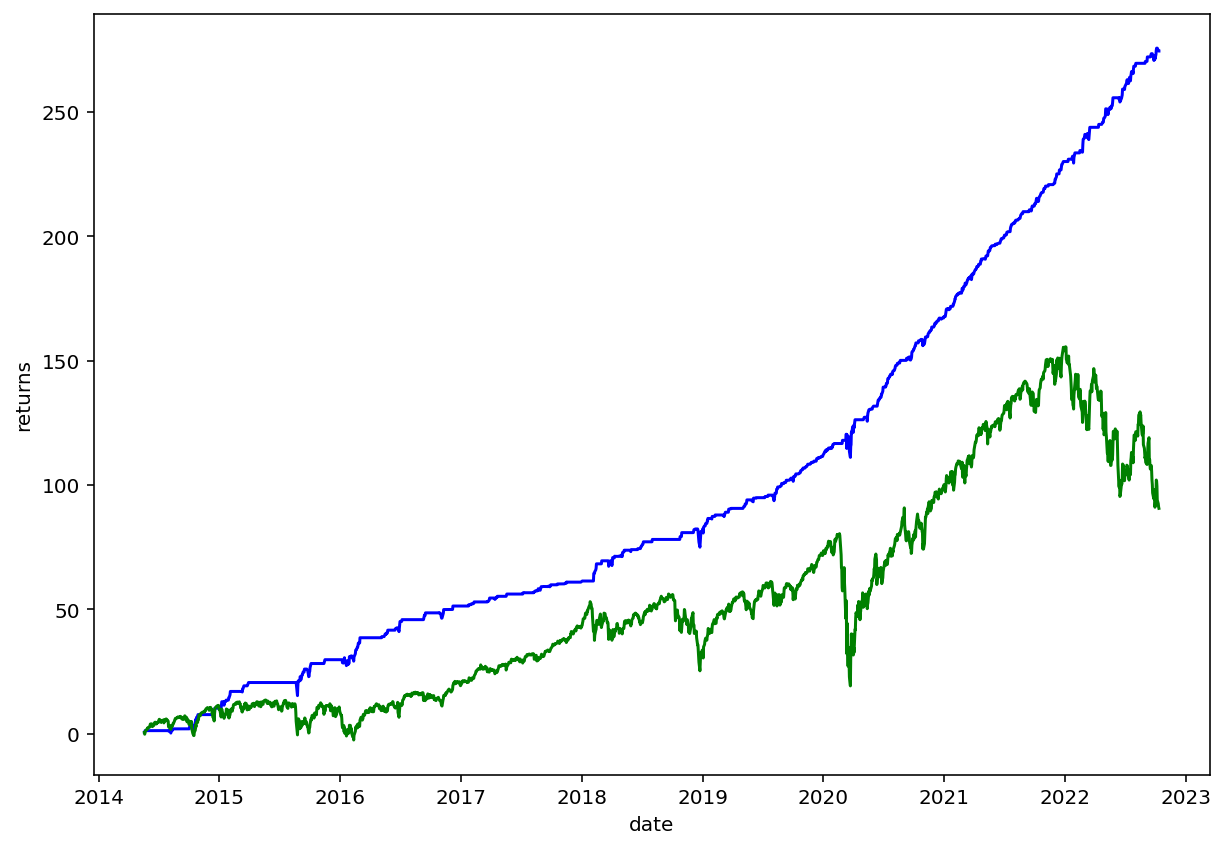

In [132]:
plt.figure(figsize = (10,7))
plt.plot(merged_df['strat cumulative'], label = 'strategy', c = 'blue')
plt.plot(merged_df['buy and hold percent change'], label = 'buy and hold', c = 'green')
plt.xlabel('date')
plt.ylabel('returns')
plt.show()